In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt                                        # for plotting
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import math
from utils.functions import load_dataset


_, train_set_x_flat, train_set_y, _, test_set_x_flat, test_set_y = load_dataset()

print(train_set_x_flat.shape)
print(train_set_y.shape)
print(test_set_x_flat.shape)
print(test_set_y.shape)

2023-06-19 04:11:15.110271: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-19 04:11:15.181789: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-19 04:11:17.092364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(209, 12288)
(209,)
(50, 12288)
(50,)


In [3]:
# normalize pixel values to be in interval [0, 1]
train_set_x_flat_n = train_set_x_flat / 255.0
test_set_x_flat_n = test_set_x_flat / 255.0

print("without normalization:")
print(train_set_x_flat[0])
print("\nwith normalization:")
print(train_set_x_flat_n[0])

without normalization:
[17 31 56 ...  0  0  0]

with normalization:
[0.06666667 0.12156863 0.21960784 ... 0.         0.         0.        ]


In [4]:
model = keras.Sequential()
model.add(layers.Flatten())
# shallow layer ↓
model.add(layers.Dense(15, activity_regularizer=keras.regularizers.l1(0.02), kernel_initializer="random_uniform", bias_initializer="random_uniform", activation="sigmoid"))
# output layer ↓ (since it's binary classification and there's one 1 output layer / the y_set has only one value, I need to use sigmoid)
model.add(layers.Dense(1, kernel_initializer="random_uniform", bias_initializer="random_uniform", activation="sigmoid"))

# learning_rate that work poorly: 0.9, 0.1
opt = tf.keras.optimizers.SGD(learning_rate=0.003, momentum=0.7)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

input_shape = train_set_x_flat_n.shape
model.build(input_shape)


In [5]:

def step_decay(epoch: int) -> float:
    initial_lrate = 0.4
    drop = 0.9
    epochs_drop = 10

    if epoch < 200:
        lrate = 0.01
    else:
        lrate = 0.003

    return lrate


lrate = keras.callbacks.LearningRateScheduler(step_decay)
callbacks_list = []
# callbacks_list = [lrate]
# do gradient descent
results = model.fit(train_set_x_flat_n, train_set_y, callbacks=callbacks_list, validation_data = (test_set_x_flat_n, test_set_y), batch_size = 16, epochs=500, verbose=1)


Epoch 1/500
14/14 [==============================] - 2s 35ms/step - loss: 0.7994 - accuracy: 0.6555 - val_loss: 0.8113 - val_accuracy: 0.3400
Epoch 2/500
14/14 [==============================] - 0s 10ms/step - loss: 0.7508 - accuracy: 0.6555 - val_loss: 0.7782 - val_accuracy: 0.3400
Epoch 3/500
14/14 [==============================] - 0s 12ms/step - loss: 0.7230 - accuracy: 0.6555 - val_loss: 0.7589 - val_accuracy: 0.3400
Epoch 4/500
14/14 [==============================] - 0s 12ms/step - loss: 0.7076 - accuracy: 0.6555 - val_loss: 0.7472 - val_accuracy: 0.3400
Epoch 5/500
14/14 [==============================] - 0s 13ms/step - loss: 0.6981 - accuracy: 0.6555 - val_loss: 0.7395 - val_accuracy: 0.3400
Epoch 6/500
14/14 [==============================] - 0s 13ms/step - loss: 0.6920 - accuracy: 0.6555 - val_loss: 0.7388 - val_accuracy: 0.3400
Epoch 7/500
14/14 [==============================] - 0s 14ms/step - loss: 0.6873 - accuracy: 0.6555 - val_loss: 0.7386 - val_accuracy: 0.3400
Epoch 

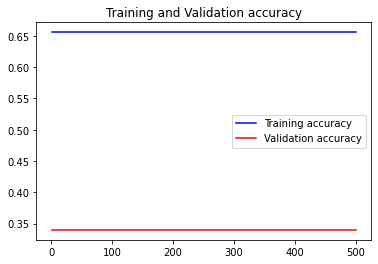

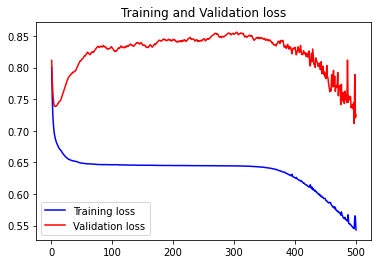

2/2 [==============================] - 0s 4ms/step


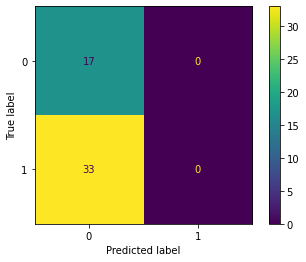

In [6]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label= 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label= 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label= 'Training loss')
plt.plot(epochs, val_loss, 'r', label= 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

num_classes = 2
# one-hot-encoding y set
y_test_multi_class = to_categorical(test_set_y, num_classes)
y_test_prediction = model.predict(test_set_x_flat_n)
y_test_prediction_rounded = [round(x) for arr in y_test_prediction for x in arr]
y_test_prediction_multi_class = keras.utils.to_categorical(y_test_prediction_rounded, num_classes)


tf.compat.v1.disable_eager_execution() # this avoids a warning message, more info in https://stackoverflow.com/questions/69136518/tensorflow-2-getting-warningtensorflowx-out-of-the-last-x-calls-to-function

#Your input to confusion_matrix must be an array of int not one hot encodings.
ConfusionMatrixDisplay.from_predictions(y_test_multi_class.argmax(axis=1), y_test_prediction_multi_class.argmax(axis=1))